## Generate UMAP embeddings for top10 samples for each feature
An experiment as an alternative to UMAP on the decoder weights.


In [2]:
# average the embeddings for top10 samples for each feature, then umap that
import pandas as pd
import numpy as np
# import h5py
import umap
import os

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name = "NOMIC_FWEDU_25k"

In [8]:
# cdf = pd.read_parquet("~/latent-scope-data/top10_64_32/clusters/cluster-005.parquet")
# cdf = pd.read_parquet("~/latent-scope-data/top10_64_32/clusters/cluster-005-labels-002.parquet")
cdf = pd.read_parquet(f"./data/top10-{name}.parquet")

In [9]:
cdf.head()

,chunk_index,chunk_text,chunk_token_count,id,url,score,dump,embedding,__index_level_0__,top_acts,top_indices,feature,activation
0,0,- simple past tense and past participle of gel...,76,<urn:uuid:ade93a67-14e4-4835-8fb6-7668fe8004db>,http://www.yourdictionary.com/gelled,2.875000,CC-MAIN-2015-18,"[0.055502143, 0.09088759, -0.1564934, -0.04632...",229004,"[0.2783777713775635, 0.2591576874256134, 0.113...","[2006.0, 0.0, 793.0, 3718.0, 5826.0, 10367.0, ...",0,0.259158
1,0,"Also found in: Thesaurus, Medical, Acronyms, E...",496,<urn:uuid:ae2f5cf3-6392-4160-a4ee-5b36b3a97e65>,https://www.thefreedictionary.com/gelatin,3.250000,CC-MAIN-2019-51,"[0.041935317, 0.10650849, -0.1574557, -0.04301...",81064,"[0.2565605938434601, 0.22474993765354156, 0.13...","[0.0, 2006.0, 5826.0, 793.0, 5945.0, 21665.0, ...",0,0.256561
2,0,"A gel (from the lat. gelu—freezing, cold, ice ...",172,<urn:uuid:c33df90e-c479-40e2-aa9b-ac6a4f0e47d9>,http://medicalxpress.com/tags/hydrogel/sort/li...,3.281250,CC-MAIN-2015-35,"[0.029497456, 0.109683335, -0.18576318, -0.034...",180126,"[0.24542075395584106, 0.09371058642864227, 0.0...","[0.0, 2006.0, 10367.0, 7655.0, 16380.0, 15780....",0,0.245421
3,7,extended periods of time can damage gelatin an...,500,<urn:uuid:16add753-dbb9-44e2-aad0-b9909c16cff5>,http://mlaiskonis.com/2014/06/07/gelatin/,2.578125,CC-MAIN-2014-41,"[0.0612519, 0.09704458, -0.17871378, -0.017184...",147957,"[0.24373508989810944, 0.15119953453540802, 0.1...","[0.0, 5826.0, 21665.0, 12673.0, 16225.0, 4502....",0,0.243735
4,1,##loid gel. gelatin forms a solution of high v...,251,<urn:uuid:acd089d5-9546-4c25-8142-ab2a5e3204cc>,http://www.foodfacts.com/ci/ingredientsoverlay...,3.250000,CC-MAIN-2016-36,"[0.060598753, 0.09118352, -0.18788467, -0.0564...",124253,"[0.2427240014076233, 0.1294490396976471, 0.087...","[0.0, 5826.0, 13791.0, 7655.0, 11963.0, 15780....",0,0.242724


In [7]:
# with h5py.File("/Users/enjalot/latent-scope-data/top10_64_32/embeddings/embedding-002.h5", "r") as f:
#     embeddings = f["embeddings"][:]
# embeddings.shape

(245760, 768)

In [15]:

# Group embeddings by feature and calculate average
grouped_embeddings = cdf.groupby('feature')['embedding'].apply(lambda x: np.mean(np.stack(x.values), axis=0))

# Convert the grouped embeddings to a numpy array
averaged_embeddings = np.array(list(grouped_embeddings))

# Normalize the averaged embeddings
averaged_embeddings = averaged_embeddings / np.linalg.norm(averaged_embeddings, axis=1, keepdims=True)

print(f"Shape of averaged embeddings: {averaged_embeddings.shape}")


Shape of averaged embeddings: (24576, 768)


In [16]:
# averaged_embeddings = []
# for index_list in cdf['indices']:
#     # Grab the embeddings for the specified indices
#     selected_embeddings = embeddings[index_list]
#     # Average the embeddings
#     averaged_embedding = np.mean(selected_embeddings, axis=0)
#     # Normalize the averaged embedding
#     normalized_embedding = averaged_embedding / np.linalg.norm(averaged_embedding)
#     averaged_embeddings.append(normalized_embedding)

# averaged_embeddings = np.array(averaged_embeddings)
# averaged_embeddings.shape


In [17]:
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [18]:
xy = reducer.fit_transform(averaged_embeddings)

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=42, verbose=True)
Mon Aug 26 21:57:04 2024 Construct fuzzy simplicial set
Mon Aug 26 21:57:04 2024 Finding Nearest Neighbors
Mon Aug 26 21:57:04 2024 Building RP forest with 13 trees
Mon Aug 26 21:57:07 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Mon Aug 26 21:57:19 2024 Finished Nearest Neighbor Search
Mon Aug 26 21:57:21 2024 Construct embedding


Epochs completed:   4%| ▍          8/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  13%| █▎         26/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  23%| ██▎        46/200 [00:02]

	completed  40  /  200 epochs


Epochs completed:  33%| ███▎       66/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  43%| ████▎      86/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  53%| █████▎     106/200 [00:06]

	completed  100  /  200 epochs


Epochs completed:  63%| ██████▎    126/200 [00:07]

	completed  120  /  200 epochs


Epochs completed:  73%| ███████▎   146/200 [00:08]

	completed  140  /  200 epochs


Epochs completed:  83%| ████████▎  166/200 [00:10]

	completed  160  /  200 epochs


Epochs completed:  93%| █████████▎ 186/200 [00:11]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:12]


Mon Aug 26 21:57:34 2024 Finished embedding


In [19]:
min_values = np.min(xy, axis=0)
max_values = np.max(xy, axis=0)

# Scale the embeddings to the range [0, 1]
xy = (xy - min_values) / (max_values - min_values)

# Scale the embeddings to the range [-1, 1]
xy = 2 * xy - 1

POINT SIZE 5 for 24576 points


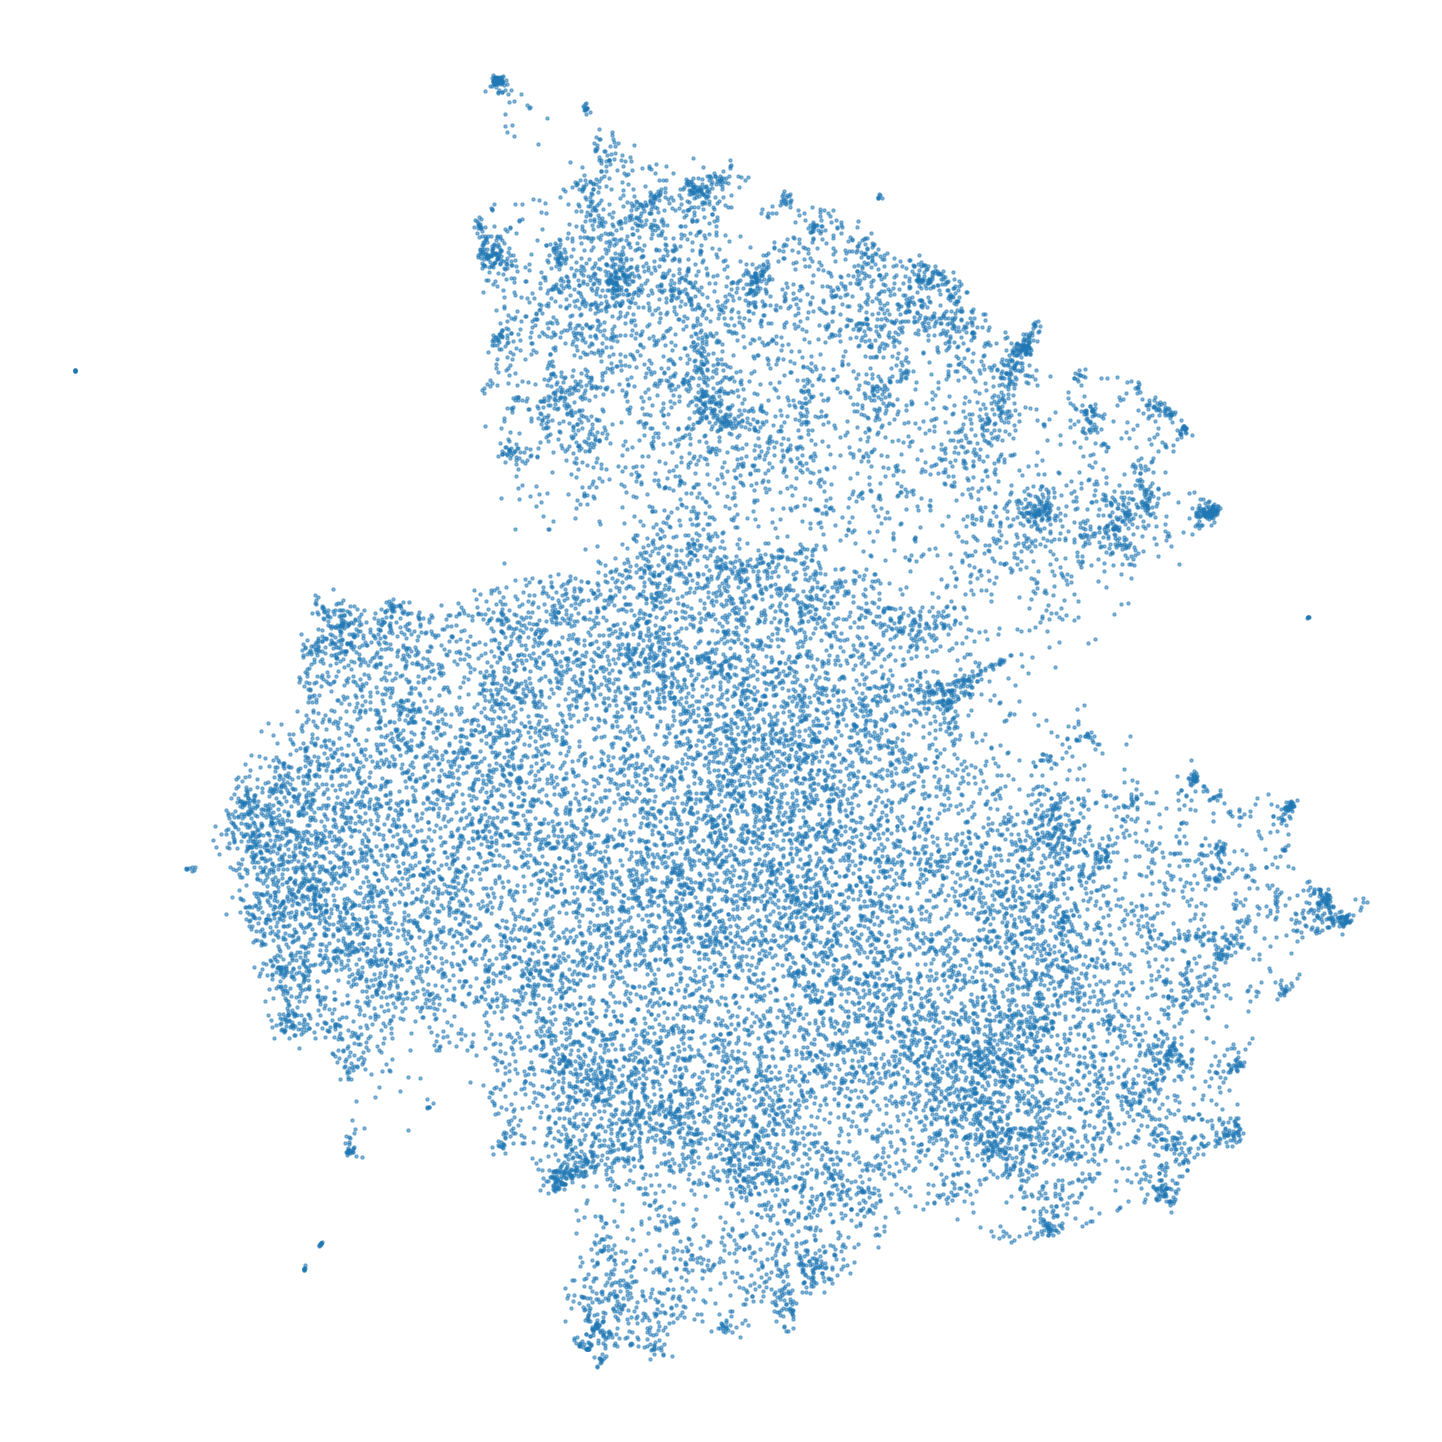

In [21]:
# generate a scatterplot of the umap embeddings and save it to a file
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14.22, 14.22))  # 1024px by 1024px at 72 dpi
point_size = 5
print("POINT SIZE", point_size, "for", xy.shape[0], "points")
plt.scatter(xy[:, 0], xy[:, 1], s=point_size, alpha=0.5)
plt.axis('off')  # remove axis
plt.gca().set_position([0, 0, 1, 1])  # remove margins
plt.show()

In [26]:
sae_id = "64_32" # because the top10 samples came from 64_32

In [22]:
df = pd.DataFrame(xy, columns=['x', 'y'])
if not os.path.exists("data"):
    os.makedirs("data")
df.to_parquet(f"data/umap-top10-{name}.parquet")
print("wrote", f"data/umap-top10-{name}.parquet")

wrote data/umap-top10-NOMIC_FWEDU_25k.parquet


In [23]:
reducer1d = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=1,
    verbose=True,
)

In [24]:
order = reducer1d.fit_transform(averaged_embeddings)
order.shape

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_components=1, n_jobs=1, n_neighbors=25, random_state=42, verbose=True)
Mon Aug 26 21:59:51 2024 Construct fuzzy simplicial set
Mon Aug 26 21:59:51 2024 Finding Nearest Neighbors
Mon Aug 26 21:59:51 2024 Building RP forest with 13 trees
Mon Aug 26 21:59:52 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Mon Aug 26 22:00:01 2024 Finished Nearest Neighbor Search
Mon Aug 26 22:00:01 2024 Construct embedding


Epochs completed:   4%| ▍          9/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▎         25/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▎        45/200 [00:02]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▎       65/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▎      85/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▎     105/200 [00:06]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▎    125/200 [00:07]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▎   145/200 [00:08]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▎  165/200 [00:10]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▎ 185/200 [00:11]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:12]


Mon Aug 26 22:00:14 2024 Finished embedding


(24576, 1)

In [25]:

# Assuming 'cdf' is a DataFrame that needs to be reordered based on 'order'
sorted_indices = np.argsort(order.flatten())



In [26]:
dfo_a = pd.DataFrame(order, columns=['order'])
if not os.path.exists("data"):
    os.makedirs("data")
dfo_a.to_parquet(f"data/1d-order-{name}-top10.parquet")

POINT SIZE 5 for 24576 points


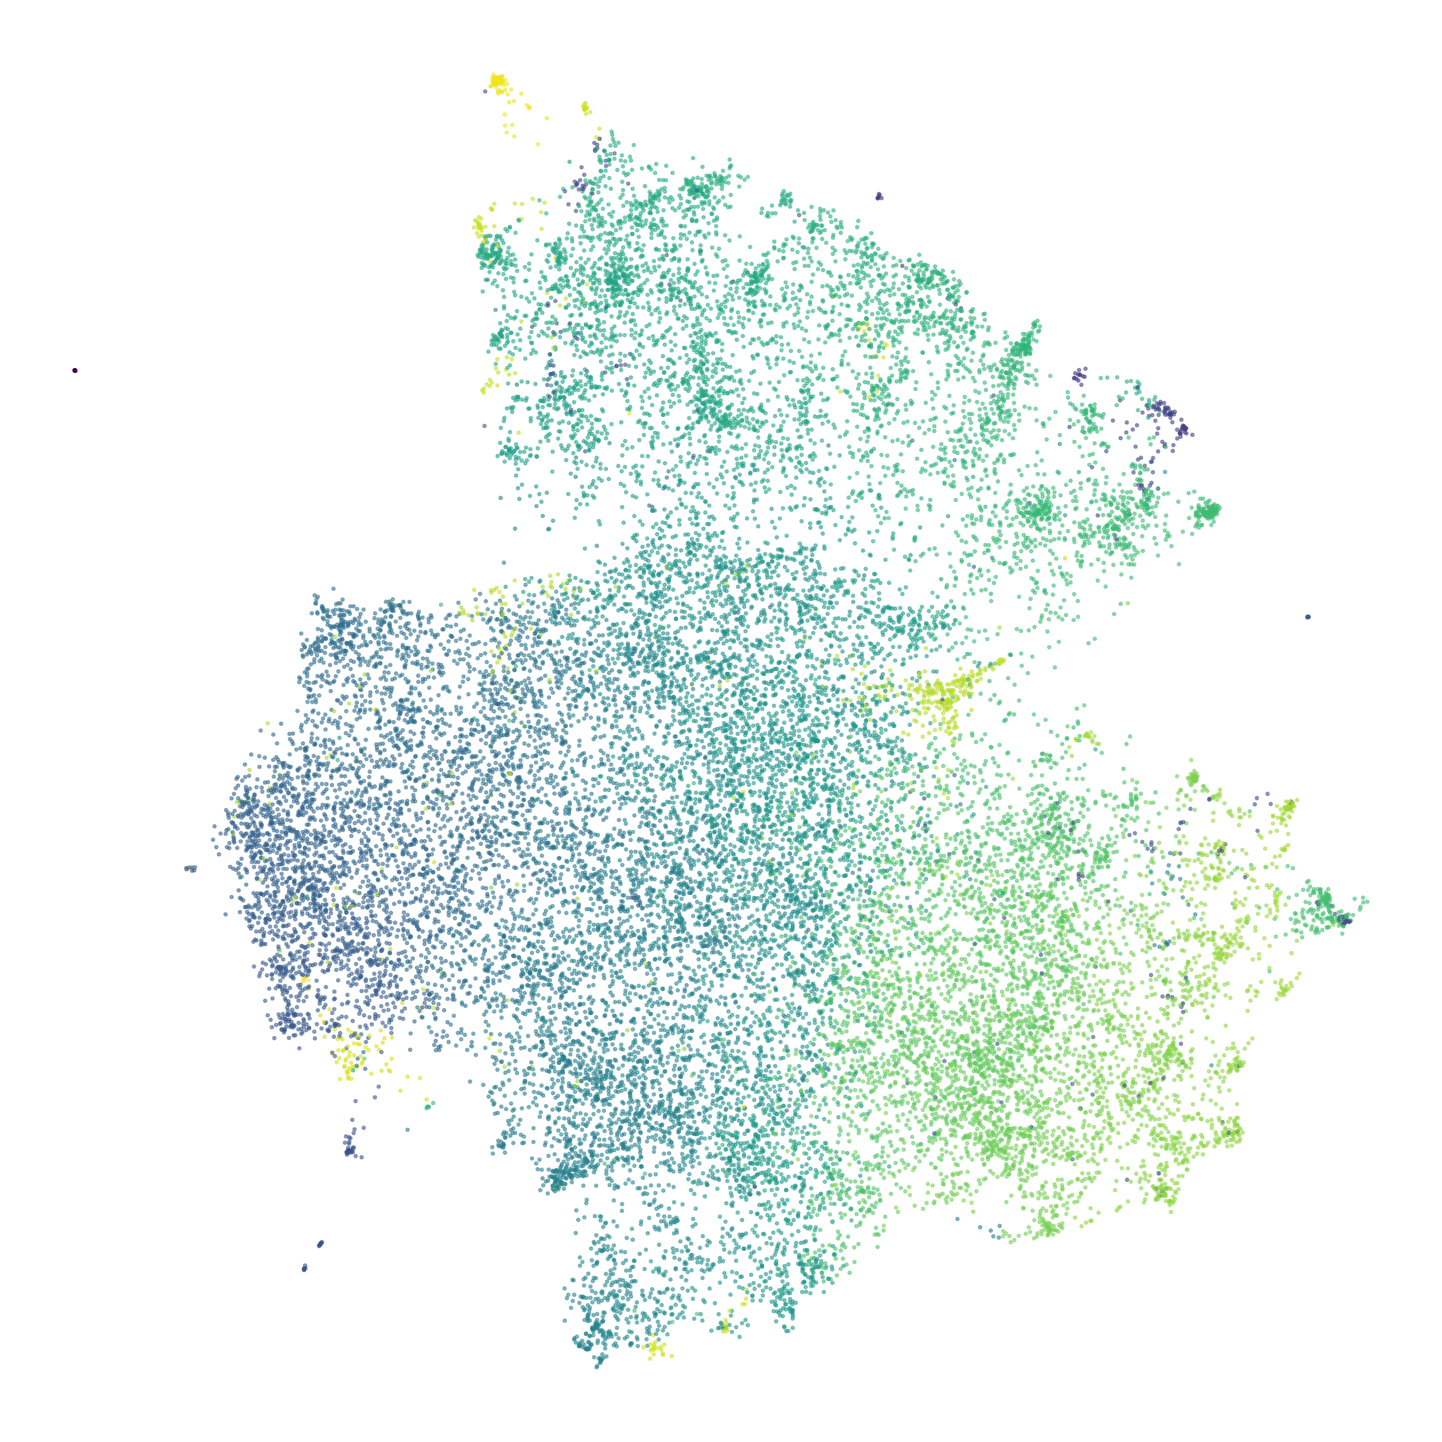

In [30]:
# generate a scatterplot of the umap embeddings and save it to a file
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14.22, 14.22))  # 1024px by 1024px at 72 dpi
point_size = 5
print("POINT SIZE", point_size, "for", xy.shape[0], "points")
# Create a colormap based on the order
cmap = plt.cm.viridis
# norm = plt.Normalize(vmin=sorted_indices.min(), vmax=sorted_indices.max())
# colors = cmap(norm(sorted_indices))
norm = plt.Normalize(vmin=order.min(), vmax=order.max())
colors = cmap(norm(order))

# Scatter plot with colors based on order
scatter = plt.scatter(xy[:, 0], xy[:, 1], s=point_size, alpha=0.5, c=colors)

# # Add a colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label('Order')

# plt.scatter(xy[:, 0], xy[:, 1], s=point_size, alpha=0.5)
plt.axis('off')  # remove axis
plt.gca().set_position([0, 0, 1, 1])  # remove margins
plt.show()

In [32]:
max(order)

array([23.232227], dtype=float32)

In [46]:
# cdf_reordered.head()

,label,description,indices,hull,labeled,label_raw
0,Ansible Configuration Management Guide,This is cluster 1379 with 10 items.,"[13790, 13791, 13792, 13793, 13794, 13795, 137...","[13795, 13791, 13799, 13792]",True,Ansible Configuration Management Guide
1,Ansible Configuration Management Overview,This is cluster 16449 with 10 items.,"[164490, 164491, 164492, 164493, 164494, 16449...","[164494, 164498, 164499, 164497, 164491, 16449...",True,Ansible Configuration Management Overview
2,Ansible Setup and Usage,This is cluster 12246 with 10 items.,"[122460, 122461, 122462, 122463, 122464, 12246...","[122466, 122462, 122464, 122460, 122468]",True,Ansible Setup and Usage
3,Ansible Automation Overview,This is cluster 3387 with 10 items.,"[33870, 33871, 33872, 33873, 33874, 33875, 338...","[33873, 33879, 33874, 33876, 33871, 33872]",True,Ansible Automation Overview
4,Ansible Basics and Concepts,This is cluster 7122 with 10 items.,"[71220, 71221, 71222, 71223, 71224, 71225, 712...","[71223, 71224, 71227, 71229, 71225]",True,Ansible Basics and Concepts


In [47]:
combined_df = pd.DataFrame({
    'feature': cdf.index,
    'label': cdf['label'],
    # 'indices': cdf['indices'],
    'x': xy[:, 0],
    'y': xy[:, 1],
    'order': sorted_indices
})


In [48]:
combined_df.head()

,feature,label,x,y,order
0,0,Gelatin and Gels,0.167784,0.471308,1379
1,1,Heathcliff and Catherines Obsession,0.520532,-0.677459,16449
2,2,Diverse Narrative Scenarios,0.060421,-0.265613,12246
3,3,Veto Power and Process,0.177264,-0.889367,3387
4,4,Historical Political Figures,0.479867,-0.558735,7122


In [49]:
combined_df.to_parquet(f"data/features-{sae_id}.parquet")
print("wrote", f"data/features-{sae_id}.parquet")

wrote data/features-64_32.parquet


In [35]:
idf = pd.read_parquet("~/latent-scope-data/top10_64_32/input.parquet")

In [36]:
idf.head()

,chunk_index,chunk_text,chunk_token_count,id,url,score,dump,__index_level_0__,top_acts,top_indices,feature,activation
0,0,- simple past tense and past participle of gel...,76,<urn:uuid:ade93a67-14e4-4835-8fb6-7668fe8004db>,http://www.yourdictionary.com/gelled,2.875000,CC-MAIN-2015-18,229004,"[0.25915753841400146, 0.02691107615828514, 0.0...","[0.0, 123.0, 155.0, 470.0, 793.0, 1089.0, 1678...",0,0.259158
1,0,"Also found in: Thesaurus, Medical, Acronyms, E...",496,<urn:uuid:ae2f5cf3-6392-4160-a4ee-5b36b3a97e65>,https://www.thefreedictionary.com/gelatin,3.250000,CC-MAIN-2019-51,81064,"[0.2565605938434601, 0.022096967324614525, 0.0...","[0.0, 110.0, 123.0, 727.0, 793.0, 1089.0, 1792...",0,0.256561
2,0,"A gel (from the lat. gelu—freezing, cold, ice ...",172,<urn:uuid:c33df90e-c479-40e2-aa9b-ac6a4f0e47d9>,http://medicalxpress.com/tags/hydrogel/sort/li...,3.281250,CC-MAIN-2015-35,180126,"[0.24542072415351868, 0.021901361644268036, 0....","[0.0, 298.0, 558.0, 793.0, 1848.0, 2006.0, 206...",0,0.245421
3,7,extended periods of time can damage gelatin an...,500,<urn:uuid:16add753-dbb9-44e2-aad0-b9909c16cff5>,http://mlaiskonis.com/2014/06/07/gelatin/,2.578125,CC-MAIN-2014-41,147957,"[0.2437349557876587, 0.03322087973356247, 0.02...","[0.0, 110.0, 694.0, 904.0, 1144.0, 1536.0, 174...",0,0.243735
4,1,##loid gel. gelatin forms a solution of high v...,251,<urn:uuid:acd089d5-9546-4c25-8142-ab2a5e3204cc>,http://www.foodfacts.com/ci/ingredientsoverlay...,3.250000,CC-MAIN-2016-36,124253,"[0.24272403120994568, 0.037509772926568985, 0....","[0.0, 120.0, 155.0, 813.0, 1036.0, 1540.0, 177...",0,0.242724


In [37]:
tdf = idf[["chunk_index", "chunk_text", "chunk_token_count", "id", "top_acts", "top_indices", "feature", "activation"]].copy()


In [38]:
tdf.to_parquet("data/samples-top10-64_32.parquet")
print("wrote", "data/samples-top10-64_32.parquet")

wrote data/samples-top10-64_32.parquet


In [39]:
chunk_size = len(tdf) // 100
chunks = [tdf.iloc[i:i + chunk_size] for i in range(0, len(tdf), chunk_size)]
if not os.path.exists("data/samples-top10-64_32"):
    os.makedirs("data/samples-top10-64_32")
for idx, chunk in enumerate(chunks):
    chunk_sorted = chunk.sort_values(by='feature')
    chunk_sorted.to_parquet(f"data/samples-top10-64_32/chunk_{idx}.parquet")
    print(f"wrote data/samples-top10-64_32/chunk_{idx}.parquet")


wrote data/samples-top10-64_32/chunk_0.parquet
wrote data/samples-top10-64_32/chunk_1.parquet
wrote data/samples-top10-64_32/chunk_2.parquet
wrote data/samples-top10-64_32/chunk_3.parquet
wrote data/samples-top10-64_32/chunk_4.parquet
wrote data/samples-top10-64_32/chunk_5.parquet
wrote data/samples-top10-64_32/chunk_6.parquet
wrote data/samples-top10-64_32/chunk_7.parquet
wrote data/samples-top10-64_32/chunk_8.parquet
wrote data/samples-top10-64_32/chunk_9.parquet
wrote data/samples-top10-64_32/chunk_10.parquet
wrote data/samples-top10-64_32/chunk_11.parquet
wrote data/samples-top10-64_32/chunk_12.parquet
wrote data/samples-top10-64_32/chunk_13.parquet
wrote data/samples-top10-64_32/chunk_14.parquet
wrote data/samples-top10-64_32/chunk_15.parquet
wrote data/samples-top10-64_32/chunk_16.parquet
wrote data/samples-top10-64_32/chunk_17.parquet
wrote data/samples-top10-64_32/chunk_18.parquet
wrote data/samples-top10-64_32/chunk_19.parquet
wrote data/samples-top10-64_32/chunk_20.parquet
wr